# Installing bwa, samtools and making the alignment 

In [ ]:
!sudo apt-get install samtools

In [3]:
!curl -L https://github.com/lh3/minimap2/releases/download/v2.17/minimap2-2.17_x64-linux.tar.bz2 --output minimap2.tar.bz2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   637  100   637    0     0   4423      0 --:--:-- --:--:-- --:--:--  4423
100 2051k  100 2051k    0     0  4195k      0 --:--:-- --:--:-- --:--:-- 6034k


In [7]:
!tar -jxvf ./minimap2.tar.bz2

minimap2-2.17_x64-linux/
minimap2-2.17_x64-linux/minimap2
minimap2-2.17_x64-linux/NEWS.md
minimap2-2.17_x64-linux/k8
minimap2-2.17_x64-linux/LICENSE.txt
minimap2-2.17_x64-linux/cookbook.md
minimap2-2.17_x64-linux/README-js.md
minimap2-2.17_x64-linux/minimap2.1
minimap2-2.17_x64-linux/paftools.js
minimap2-2.17_x64-linux/README.md


In [23]:
!./minimap2-2.17_x64-linux/minimap2 --MD -H -a -t 4 reference.fasta pacbio_40x.fq.gz > pacbio.sam
!samtools view -S -b pacbio.sam > pacbio.bam
!samtools sort pacbio.bam > pacbio_sorted.bam
!samtools index pacbio_sorted.bam

[M::mm_idx_gen::0.198*1.23] collected minimizers
[M::mm_idx_gen::0.235*1.35] sorted minimizers
[M::main::0.235*1.35] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.249*1.33] mid_occ = 12
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.259*1.32] distinct minimizers: 513422 (82.88% are singletons); average occurrences: 1.235; average spacing: 7.318
[WARNING] wrong FASTA/FASTQ record. Continue anyway.
[M::worker_pipeline::123.400*1.90] mapped 34054 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: ./minimap2-2.17_x64-linux/minimap2 --MD -H -a -t 4 reference.fasta pacbio_40x.fq.gz
[M::main] Real time: 123.455 sec; CPU: 234.453 sec; Peak RSS: 1.617 GB


In [25]:
!./minimap2-2.17_x64-linux/minimap2 --MD -H -a -t 4 reference.fasta ONT_2D.fastq.gz > ONT_2D.sam
!samtools view -S -b ONT_2D.sam > ONT_2D.bam
!samtools sort ONT_2D.bam > ONT_2D_sorted.bam
!samtools index ONT_2D_sorted.bam

[M::mm_idx_gen::0.185*1.00] collected minimizers
[M::mm_idx_gen::0.221*1.16] sorted minimizers
[M::main::0.221*1.16] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.233*1.15] mid_occ = 12
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.243*1.14] distinct minimizers: 513422 (82.88% are singletons); average occurrences: 1.235; average spacing: 7.318
[M::worker_pipeline::55.383*1.88] mapped 30810 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: ./minimap2-2.17_x64-linux/minimap2 --MD -H -a -t 4 reference.fasta ONT_2D.fastq.gz
[M::main] Real time: 55.408 sec; CPU: 103.951 sec; Peak RSS: 0.961 GB


In [26]:
!samtools flagstat pacbio_sorted.bam

32097 + 0 in total (QC-passed reads + QC-failed reads)
1062 + 0 secondary
225 + 0 supplementary
0 + 0 duplicates
29584 + 0 mapped (92.17% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [27]:
!pip install pysam

     |████████████████████████████████| 9.9MB 3.5MB/s 


# Statistics counting functions

In [29]:
import pysam
import matplotlib.pyplot as plt
import matplotlib
import statistics
import numpy as np
from collections import defaultdict, Counter
import pandas as pd
import seaborn as sns

In [30]:
def process_it_read_distribution(samfile: pysam.AlignmentFile):
  print("===========")
  print('Coverage stats')
  distribution = []
  for pileupcolumn in samfile.pileup():
      distribution.append(pileupcolumn.get_num_aligned())
  print(f'Mean coverage is {sum(distribution) / len(distribution)}')
  print(f'The percent of genome covered is {100 - 100 * (sum(x == 0 for x in distribution) / len(distribution))}')
  plt.plot(distribution, label="Coverage distribution")
  plt.show()

def count_indel_stats(samfile: pysam.AlignmentFile):
  print("===========")
  print('Indel distribution stats')
  indel_stats = []
  for position in samfile.pileup():
     for res in position.get_query_sequences(add_indels=True):
       if '+' in res:
          res = ''.join(i for i in res if i.isnumeric())
          l = int(res)
          indel_stats.append(l)
  perc_25 = np.percentile(np.array(indel_stats), 2.5)
  perc_975 = np.percentile(np.array(indel_stats), 97.5)
  print(f'The mean indel length is {statistics.mean(indel_stats)}')
  print(f'The standard deviation of indel length is {statistics.stdev(indel_stats)}')
  print(f'The minimum 95% interval of indel length is [{perc_25}, {perc_975}]')
  print(f'The maximum indel length is {max(indel_stats)}')

def process_errors_with_indels(samfile: pysam.AlignmentFile):
  print("===========")
  print('Error stats')
  errors_map = defaultdict(lambda: defaultdict(int))
  sum_nucls = 0
  mismatch_qualities = []
  insertion_qualities = [] 
  for position in samfile.pileup():
    position_values = position.get_query_sequences(add_indels=True)
    quality_values = position.get_query_qualities()
    if len(position_values) == 0:
      continue
    counter = Counter(position_values)
    ref_value = counter.most_common(1)[0][0].upper()[0]
    if ref_value not in 'ACTG':
      continue
    for v, q in zip(position_values, quality_values):
      sum_nucls += 1
      v = v.upper()
      if v != ref_value:
        if v in 'ACTG':
          mismatch_qualities.append(q)
          errors_map[ref_value][v] += 1
        elif v == '*':
          errors_map[ref_value]['-'] += 1
        elif '+' in v:
          insertion_qualities.append(q)
          v = v[2:]
          while v[0].isnumeric():
            v = v[1:]
          for i in v:
            errors_map['-'][i] += 1
        elif '-' in v:
          res = ''.join(i for i in v if i.isnumeric())
          l = int(res)
          errors_map[ref_value]['-'] += l
        else:
          print(f'Error parsing {v}')
  df = pd.DataFrame(errors_map)
  df = df.sort_index()
  df = df.reindex(sorted(df.columns), axis=1)
  print(df.to_string(na_rep='0'))
  print(f'Error percent is {sum(sum(v.values()) for v in errors_map.values()) / sum_nucls * 100}')

  print()
  print("===========")
  print('Mismatch/insertion quality stats')
  print()
  print('Mismatch stats:')
  perc_25 = np.percentile(np.array(mismatch_qualities), 2.5)
  perc_975 = np.percentile(np.array(mismatch_qualities), 97.5)
  print(f'The mean mismatch quality is {statistics.mean(mismatch_qualities)}')
  print(f'The standard deviation of mismatch quality is {statistics.stdev(mismatch_qualities)}')
  print(f'The minimum 95% interval of mismatch quality is [{perc_25}, {perc_975}]')
  print(f'The minimum mismatch quality is {min(mismatch_qualities)}')
  print(f'The maximum mismatch quality is {max(mismatch_qualities)}')
  
  print()
  print('Insertion stats:')
  perc_25 = np.percentile(np.array(insertion_qualities), 2.5)
  perc_975 = np.percentile(np.array(insertion_qualities), 97.5)
  print(f'The mean insertion quality is {statistics.mean(insertion_qualities)}')
  print(f'The standard deviation of insertion quality is {statistics.stdev(insertion_qualities)}')
  print(f'The minimum 95% interval of insertion quality is [{perc_25}, {perc_975}]')
  print(f'The minimum mismatch quality is {min(insertion_qualities)}')
  print(f'The maximum insertion quality is {max(insertion_qualities)}')

def find_homopolymer_indels(samfile: pysam.AlignmentFile):
  print("===========")
  print('Indels stats near homopolymers')
  indels_sum = 0
  homo_indels_sum = 0
  for position in samfile.pileup():
    position_values = position.get_query_sequences(add_indels=True)
    pileups = position.pileups
    for read in pileups:
      if read.indel:
        indels_sum += 1
        alignment = read.alignment
        end = alignment.query_alignment_sequence[read.query_position_or_next - 3 : read.query_position_or_next]
        start = alignment.query_alignment_sequence[read.query_position_or_next: read.query_position_or_next + 3]
        if start in ['AAA', 'CCC', 'TTT', 'GGG'] or end in ['AAA', 'CCC', 'TTT', 'GGG']:
          homo_indels_sum += 1
  print(f'Percent of indels near homopolymers is {round(homo_indels_sum / indels_sum * 100, 2)}')

PROCESSING THE PACBIO FILE
Coverage stats
Mean coverage is 12.432427486839057
The percent of genome covered is 97.88170507632539


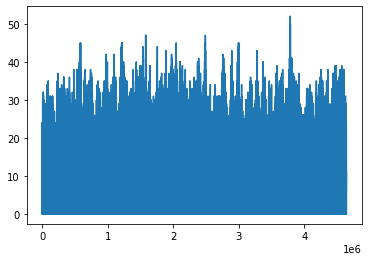

Indel distribution stats
The mean indel length is 1.3675117359287527
The standard deviation of indel length is 3.7327333896137938
The minimum 95% interval of indel length is [1.0, 4.0]
The maximum indel length is 1714
Error stats
           -         A         C         G         T
-          0  654462.0  697191.0  855439.0  635209.0
A  1111296.0         0   48945.0   43075.0   42055.0
C  1286500.0   38803.0         0   43662.0   36456.0
G  1379741.0   36433.0   41787.0         0   38773.0
T  1072452.0   42021.0   41957.0   48270.0         0
Error percent is 14.254647722622046

Mismatch/insertion quality stats

Mismatch stats:
The mean mismatch quality is 13.465674571965028
The standard deviation of mismatch quality is 0.5087411536646687
The minimum 95% interval of mismatch quality is [13.0, 14.0]
The minimum mismatch quality is 13
The maximum mismatch quality is 15

Insertion stats:
The mean insertion quality is 13.570338881273994
The standard deviation of insertion quality is 0.51531

In [31]:
print('PROCESSING THE PACBIO FILE')
samfile = pysam.AlignmentFile("pacbio_sorted.bam", "rb")
process_it_read_distribution(samfile=samfile)
count_indel_stats(samfile=samfile)
process_errors_with_indels(samfile=samfile)
find_homopolymer_indels(samfile)

PROCESSING THE NANOPORE FILE
Coverage stats
Mean coverage is 22.96393432729663
The percent of genome covered is 99.99963359502551


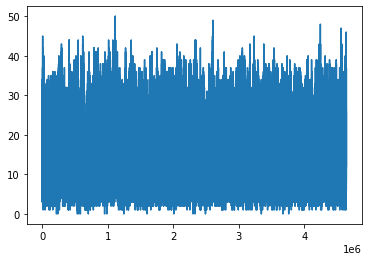

Indel distribution stats
The mean indel length is 1.7486942679658837
The standard deviation of indel length is 9.530802018428576
The minimum 95% interval of indel length is [1.0, 5.0]
The maximum indel length is 1196
Error stats
          -          A          C          G          T
-         0  1157758.0  1496328.0  1214805.0  1285298.0
A  191553.0          0    18490.0    51104.0    15531.0
C  178037.0    16785.0          0    13425.0    54821.0
G  188254.0    53096.0    12810.0          0    15994.0
T  176071.0    15151.0    55784.0    17383.0          0
Error percent is 5.893161473119018

Mismatch/insertion quality stats

Mismatch stats:
The mean mismatch quality is 16.597933449675946
The standard deviation of mismatch quality is 4.267779139780447
The minimum 95% interval of mismatch quality is [13.0, 28.0]
The minimum mismatch quality is 13
The maximum mismatch quality is 93

Insertion stats:
The mean insertion quality is 19.5166200210678
The standard deviation of insertion quali

In [32]:
print('PROCESSING THE NANOPORE FILE')
samfile = pysam.AlignmentFile("ONT_2D_sorted.bam", "rb")
process_it_read_distribution(samfile=samfile)
count_indel_stats(samfile=samfile)
process_errors_with_indels(samfile=samfile)
find_homopolymer_indels(samfile)
